In [95]:
from itertools import repeat

from matplotlib import cm
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

import numpy as np

import os

import pandas as pd

import plotly.graph_objects as go

import seaborn as sn

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorboardX import SummaryWriter

import torch
from torch.autograd import Variable
from torch import nn
from torch import optim
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

from tqdm import tqdm

## Importing the Dataset for all the stocks

__[Click here for complete S&P 500 stock Dataset](https://www.kaggle.com/camnugent/sandp500)__

<div class="alert alert-block alert-info">
<b>Column Details for all_stocks_5yr file</b>
</div>

* Date - in format: yy-mm-dd
* Open - price of the stock at market open (this is NYSE data so all in USD)
* High - Highest price reached in the day
* Low Close - Lowest price reached in the day
* Volume - Number of shares traded
* Name - the stock's ticker name 

In [2]:
data = pd.read_csv("dataset/all_stocks_5yr.csv")

# EDA

In [3]:
data.head()

date   open   high    low  close    volume Name
0  2013-02-08  15.07  15.12  14.63  14.75   8407500  AAL
1  2013-02-11  14.89  15.01  14.26  14.46   8882000  AAL
2  2013-02-12  14.45  14.51  14.10  14.27   8126000  AAL
3  2013-02-13  14.30  14.94  14.25  14.66  10259500  AAL
4  2013-02-14  14.94  14.96  13.16  13.99  31879900  AAL

In [4]:
type(data['date'][0])

str

### Converting the datatype of column "date" to datetime

In [5]:
data.loc[:, 'date'] = pd.to_datetime(data.loc[:,'date'], format="%Y/%m/%d")

### List of all companies

In [6]:
stock_name = set(data["Name"])

In [7]:
stock_name

{'A',
 'AAL',
 'AAP',
 'AAPL',
 'ABBV',
 'ABC',
 'ABT',
 'ACN',
 'ADBE',
 'ADI',
 'ADM',
 'ADP',
 'ADS',
 'ADSK',
 'AEE',
 'AEP',
 'AES',
 'AET',
 'AFL',
 'AGN',
 'AIG',
 'AIV',
 'AIZ',
 'AJG',
 'AKAM',
 'ALB',
 'ALGN',
 'ALK',
 'ALL',
 'ALLE',
 'ALXN',
 'AMAT',
 'AMD',
 'AME',
 'AMG',
 'AMGN',
 'AMP',
 'AMT',
 'AMZN',
 'ANDV',
 'ANSS',
 'ANTM',
 'AON',
 'AOS',
 'APA',
 'APC',
 'APD',
 'APH',
 'APTV',
 'ARE',
 'ARNC',
 'ATVI',
 'AVB',
 'AVGO',
 'AVY',
 'AWK',
 'AXP',
 'AYI',
 'AZO',
 'BA',
 'BAC',
 'BAX',
 'BBT',
 'BBY',
 'BDX',
 'BEN',
 'BF.B',
 'BHF',
 'BHGE',
 'BIIB',
 'BK',
 'BLK',
 'BLL',
 'BMY',
 'BRK.B',
 'BSX',
 'BWA',
 'BXP',
 'C',
 'CA',
 'CAG',
 'CAH',
 'CAT',
 'CB',
 'CBG',
 'CBOE',
 'CBS',
 'CCI',
 'CCL',
 'CDNS',
 'CELG',
 'CERN',
 'CF',
 'CFG',
 'CHD',
 'CHK',
 'CHRW',
 'CHTR',
 'CI',
 'CINF',
 'CL',
 'CLX',
 'CMA',
 'CMCSA',
 'CME',
 'CMG',
 'CMI',
 'CMS',
 'CNC',
 'CNP',
 'COF',
 'COG',
 'COL',
 'COO',
 'COP',
 'COST',
 'COTY',
 'CPB',
 'CRM',
 'CSCO',
 'CSRA',
 'CSX',

In [8]:
stock_name = list(stock_name)

In [9]:
len(stock_name)

505

### Histogram Visualization

In [34]:
def histogram_visualization(stocks_to_visualize=['AAPL'], opacity=0.70, signal_type="close"):
    """
    stocks_to_visualize: list
    List of stocks to visulaize
    default: ['AAPL']
    
    opacity: float(0 to 1)
    opacity of histogram
    default: 0.7
    
    signal_type: str
    type of column to visulaize
    default: "close"
    
    """
    
    fig = go.Figure()

    for company_names in stocks_to_visualize:
        fig.add_trace(go.Histogram(x = data[data["Name"] == company_names] [signal_type],
                                      name=company_names,
                                   ))


    # Overlay both histograms
    fig.update_layout(barmode='overlay',
                     xaxis_title_text = 'Value of '+signal_type, 
                     yaxis_title_text = 'Count')


    # Reducing the opacity to see all histograms
    fig.update_traces(opacity = 0.70)
    
    return fig
    

In [37]:
# open
histogram_visualization(stocks_to_visualize = stock_name[:2], signal_type="open")

In [23]:
# close
histogram_visualization(stocks_to_visualize = stock_name[:2], signal_type="close")

In [24]:
# high
histogram_visualization(stocks_to_visualize = stock_name[:2], signal_type="high")

In [25]:
# low
histogram_visualization(stocks_to_visualize = stock_name[:2], signal_type="low")

In [26]:
# volume
histogram_visualization(stocks_to_visualize = stock_name[:2], signal_type="volume")

### Line Graph Visualization

In [55]:
def linegraph_visualization(stocks_to_visualize=['AAPL'], mode="lines", signal_type="close", rolling_win_length=1):
    """
    stocks_to_visualize: list
    List of stocks to visulaize
    default: ['AAPL']
    
    mode: str
    -> 'lines'
    -> 'lines+markers'
    -> 'markers'
    mode of visualization
    default:'lines'
    
    signal_type: str
    type of column to visulaize
    default: "close"
    
    rolling_win_length: int
    length of the rolling window for smoothening the signal
    default: 1
    
    """
    
    
    fig = go.Figure()
    
    for company_names in stocks_to_visualize:
        fig.add_trace(go.Scatter(x = data[data["Name"] == company_names]['date'],
                                 y = data[data["Name"] == company_names][signal_type].rolling(rolling_win_length).mean(),
                                 mode = mode,
                                 name = company_names))

    fig.update_layout(yaxis_title_text = 'Value of '+signal_type, 
                      xaxis_title_text = 'Date')

    return fig

In [62]:
# close
linegraph_visualization(stocks_to_visualize = stock_name[:2], mode="lines", signal_type="close", rolling_win_length=1)

In [63]:
# open
linegraph_visualization(stocks_to_visualize = stock_name[:2], mode="lines", signal_type="open", rolling_win_length=1)

In [64]:
# high
linegraph_visualization(stocks_to_visualize = stock_name[:2], mode="lines", signal_type="high", rolling_win_length=1)

In [65]:
# high
linegraph_visualization(stocks_to_visualize = stock_name[:2], mode="lines", signal_type="low", rolling_win_length=1)

In [66]:
# volume
linegraph_visualization(stocks_to_visualize = stock_name[:2], mode="lines", signal_type="volume", rolling_win_length=1)

### Correlation HeatMap Visualization

In [83]:
def correlation_heatmap(stock_name="AAPL", method='spearman'):
    """
    stocks_to_visualize: str
    Name of the stock to visulaize
    default: 'AAPL'
    
    mode: str
    -> 'pearson' : standard correlation coefficient
    -> 'kendall' : Kendall Tau correlation coefficient
    -> 'spearman' : Spearman rank correlation
    type of correlation
    default:'spearman'
    """
    
    
    corr = data.append(data[data['Name']==stock_name]).corr(method = method)
    
    plt.figure(figsize = (20,20))
    
    return sn.heatmap(corr, 
               vmax =.8, 
               linewidths = 0.05,
               square = True,
               fmt = ".2f",
               annot = True,
               cmap = 'RdBu',
               linecolor = 'white',
               annot_kws = {'size':10})

<AxesSubplot:>

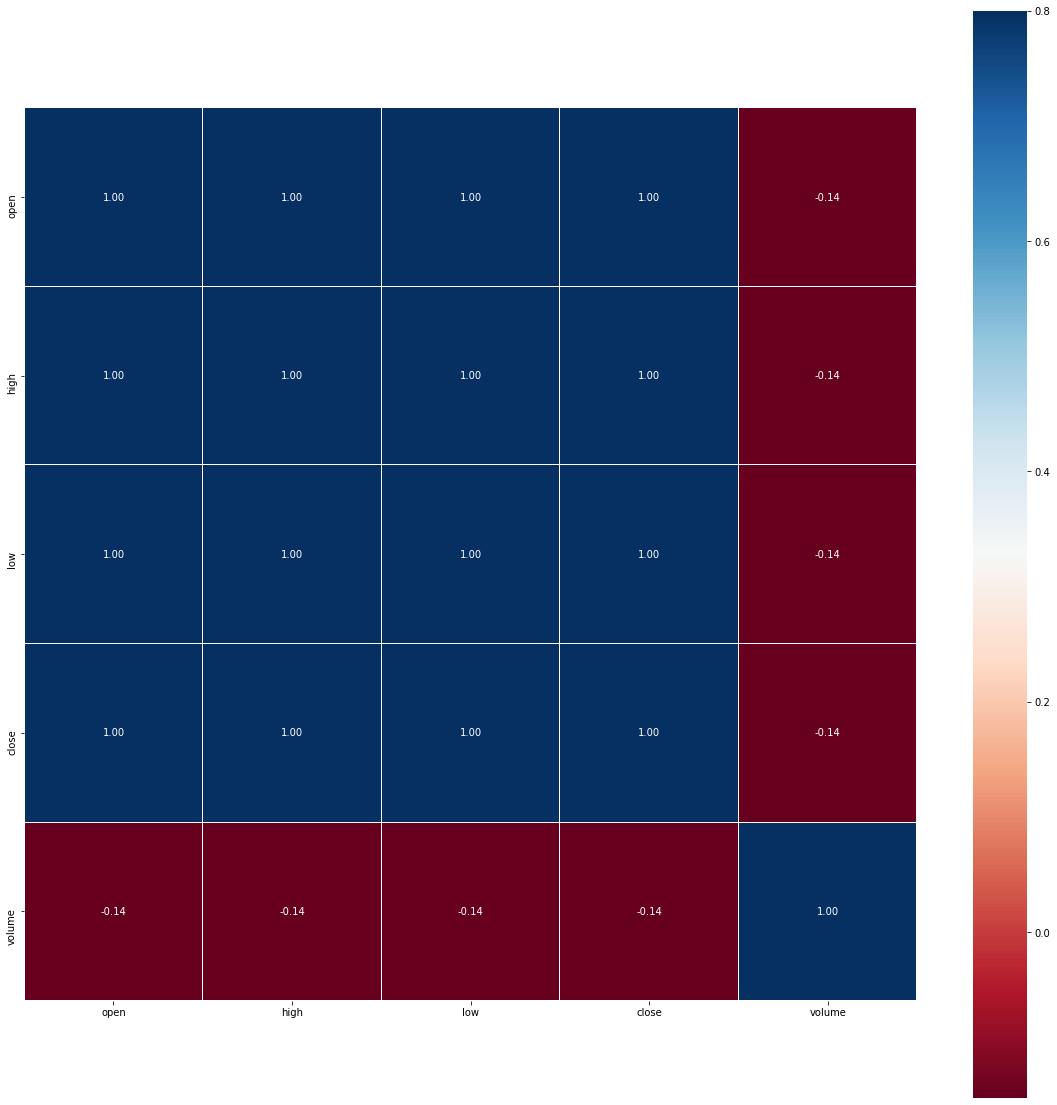

In [84]:
correlation_heatmap(stock_name='AZO', method='pearson')

## Batch Generator Class for the dataset

In [85]:
class SP500(Dataset):
    def __init__(self, folder_dataset, T=10, symbols=['AAPL'], use_columns=['date', 'close'], start_date='2012-01-01',
                 end_date='2015-12-31', step=1):
        """
        folder_dataset: str
        dataset destination
        default : NA
        
        T: int
        number of look back points
        default : 10
        
        symbols: list of str
        list of companies
        default : ['AAPL']
        
        use_columns: list of str
        columns used for creating batch 
        default : ['date', 'close']
        
        start_date: str, date format YYY-MM-DD
        starting date
        default : '2012-01-01' 
        
        end_date: str, date format YYY-MM-DD
        ending date
        default : '2015-12-31'
        
        """
        
        self.scaler = MinMaxScaler()
        self.symbols = symbols
        if len(symbols)==0:
            print("No Symbol was specified")
            return
        self.start_date = start_date
        if len(start_date)==0:
            print("No start date was specified")
            return
        self.end_date = end_date
        if len(end_date)==0:
            print("No end date was specified")
            return
        self.use_columns = use_columns
        if len(use_columns)==0:
            print("No column was specified")
            return
        self.T = T

        
        # Create output dataframe
        self.dates = pd.date_range(self.start_date, self.end_date)
        self.df_data = pd.DataFrame(index=self.dates)

        
        # Read csv files corresponding to symbols
        for symbol in symbols:
            fn = os.path.join(folder_dataset, symbol + "_data.csv")
            fn =  folder_dataset + "/" + symbol + "_data.csv"
            print(fn)
            df_current = pd.read_csv(fn, index_col='date', usecols=self.use_columns, na_values='nan', parse_dates=True)
            df_current = df_current.rename(columns={'close': symbol})
            self.df_data = self.df_data.join(df_current)

            
        # Replace NaN values with forward then backward filling
        self.df_data.fillna(method='ffill', inplace=True, axis=0)
        self.df_data.fillna(method='bfill', inplace=True, axis=0)
        
        
        #self.numpy_data = self.df_data.as_matrix(columns=self.symbols)
        self.numpy_data = self.df_data[self.symbols].to_numpy()
        self.train_data = self.scaler.fit_transform(self.numpy_data)

        self.chunks = torch.FloatTensor(self.train_data).unfold(0, self.T, step).permute(0, 2, 1)

    def __getitem__(self, index):

        x = self.chunks[index, :-1, :]
        y = self.chunks[index, -1, :]
        return x, y

    def __len__(self):
        return self.chunks.size(0)


## Network Architecture 

In [86]:
class DilatedNet(nn.Module):
    def __init__(self, num_securities=5, hidden_size=64, dilation=2, T=10):
        
        """
        num_securities: int
        size of final layer (output of network)
        default: 5 
        
        hidden_size: int
        size of hidden layers
        
        dilation: int
        dilation factor
        
        T: int
        number of look back points
        
        """
        
        super(DilatedNet, self).__init__()
        self.dilation = dilation
        self.hidden_size = hidden_size
        # First Layer
        # Input
        self.dilated_conv1 = nn.Conv1d(num_securities, hidden_size, kernel_size=2, dilation=self.dilation)
        self.relu1 = nn.ReLU()

        # Layer 2
        self.dilated_conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=1, dilation=self.dilation)
        self.relu2 = nn.ReLU()

        # Layer 3
        self.dilated_conv3 = nn.Conv1d(hidden_size, hidden_size, kernel_size=1, dilation=self.dilation)
        self.relu3 = nn.ReLU()

        # Layer 4
        self.dilated_conv4 = nn.Conv1d(hidden_size, hidden_size, kernel_size=1, dilation=self.dilation)
        self.relu4 = nn.ReLU()

        # Output layer
        self.conv_final = nn.Conv1d(hidden_size, num_securities, kernel_size=1)

        self.T = T

    def forward(self, x):
        """
        :param x: Pytorch Variable, batch_size x n_stocks x T
        :return:
        """

        # First layer
        out = self.dilated_conv1(x)
        out = self.relu1(out)

        # Layer 2:
        out = self.dilated_conv2(out)
        out = self.relu2(out)

        # Layer 3:
        out = self.dilated_conv3(out)
        out = self.relu3(out)

        # Layer 4:
        out = self.dilated_conv4(out)
        out = self.relu4(out)

        # Final layer
        out = self.conv_final(out)
        out = out[:, :, -1]

        return out
    

In [87]:
use_cuda = False
writer = SummaryWriter()

### Hyper Parameters

In [97]:
learning_rate = 0.001
batch_size = 16
display_step = 500
max_epochs = 1000
n_hidden1 = 128
n_hidden2 = 128

n_steps_encoder = 20  # time steps, length of the sliding time window
T = 30



# List of companies
symbols = ['GOOGL', 'AAPL', 'AMZN', 'FB', 'ZION', 'NVDA', 'GS']

n_stocks = len(symbols)
n_output = n_stocks


start_date = '2013-01-01'
end_date = '2013-10-31'   

### Training Dataset

In [90]:
dset = SP500('dataset/individual_stocks_5yr',
             symbols=symbols,
             start_date='2013-01-01',
             end_date='2013-07-31',
             T=T,
             step=1)

dataset/individual_stocks_5yr/GOOGL_data.csv
dataset/individual_stocks_5yr/AAPL_data.csv
dataset/individual_stocks_5yr/AMZN_data.csv
dataset/individual_stocks_5yr/FB_data.csv
dataset/individual_stocks_5yr/ZION_data.csv
dataset/individual_stocks_5yr/NVDA_data.csv
dataset/individual_stocks_5yr/GS_data.csv


In [91]:
train_loader = DataLoader(dset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4,
                          pin_memory=False  
                          )

### Network Parameters

In [93]:
model = DilatedNet(num_securities=n_stocks, T=T)

# Optimizer
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=0.0)  # n

scheduler_model = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=1.0)

# loss function
criterion = nn.MSELoss(reduction='mean')

## Training

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch =  0
Loss =  tensor(0.0032)


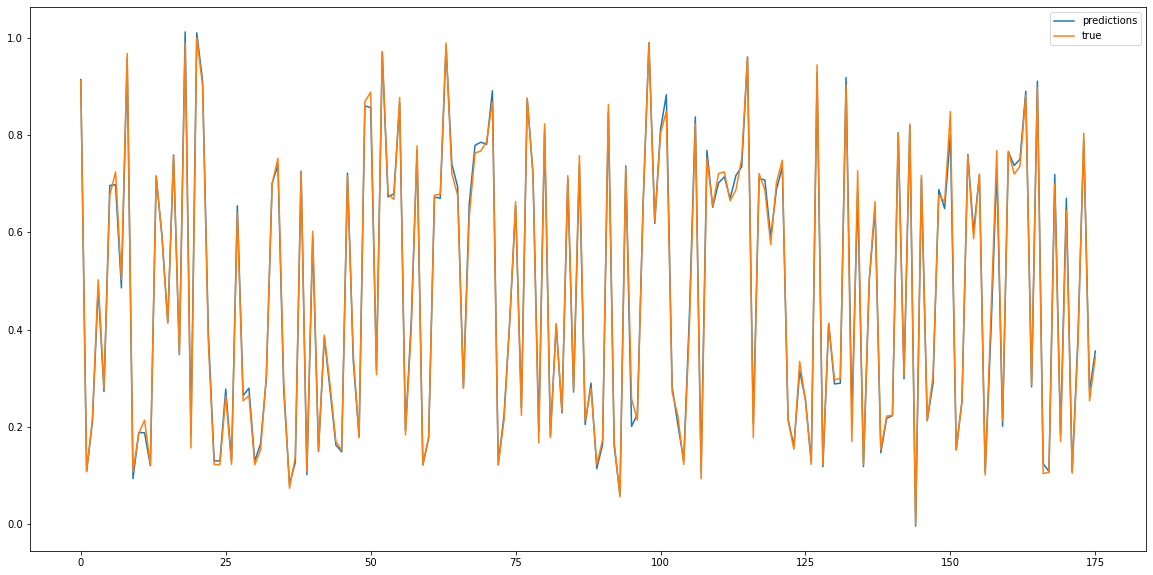

  0%|          | 1/250 [00:00<01:26,  2.87it/s]/home/kishan/Documents/Projects/deepsurvival/deep_survival/lib/python3.8/site-packages/torch/nn/modules/loss.py:446: UserWarning:

Using a target size (torch.Size([1, 16, 7])) that is different to the input size (torch.Size([16, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

  8%|▊         | 20/250 [00:03<00:37,  6.08it/s]

Epoch =  20
Loss =  tensor(0.0035)


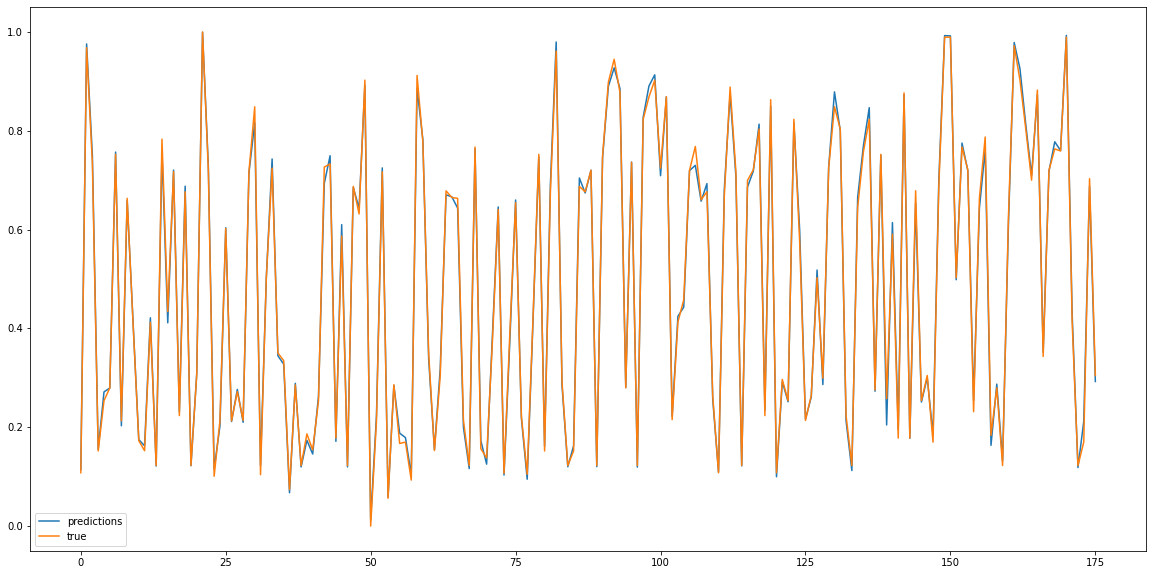

  8%|▊         | 21/250 [00:04<01:24,  2.71it/s]/home/kishan/Documents/Projects/deepsurvival/deep_survival/lib/python3.8/site-packages/torch/nn/modules/loss.py:446: UserWarning:

Using a target size (torch.Size([1, 16, 7])) that is different to the input size (torch.Size([16, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

 16%|█▌        | 40/250 [00:07<00:31,  6.68it/s]

Epoch =  40
Loss =  tensor(0.0042)


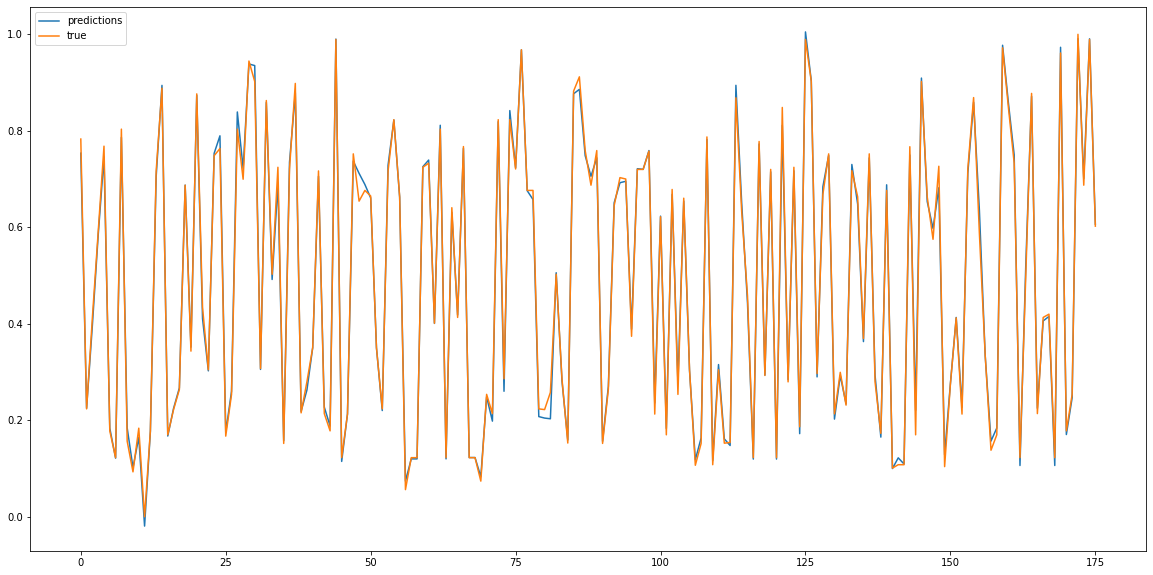

 16%|█▋        | 41/250 [00:07<00:41,  4.98it/s]/home/kishan/Documents/Projects/deepsurvival/deep_survival/lib/python3.8/site-packages/torch/nn/modules/loss.py:446: UserWarning:

Using a target size (torch.Size([1, 16, 7])) that is different to the input size (torch.Size([16, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

 24%|██▍       | 60/250 [00:10<00:29,  6.45it/s]

Epoch =  60
Loss =  tensor(0.0031)


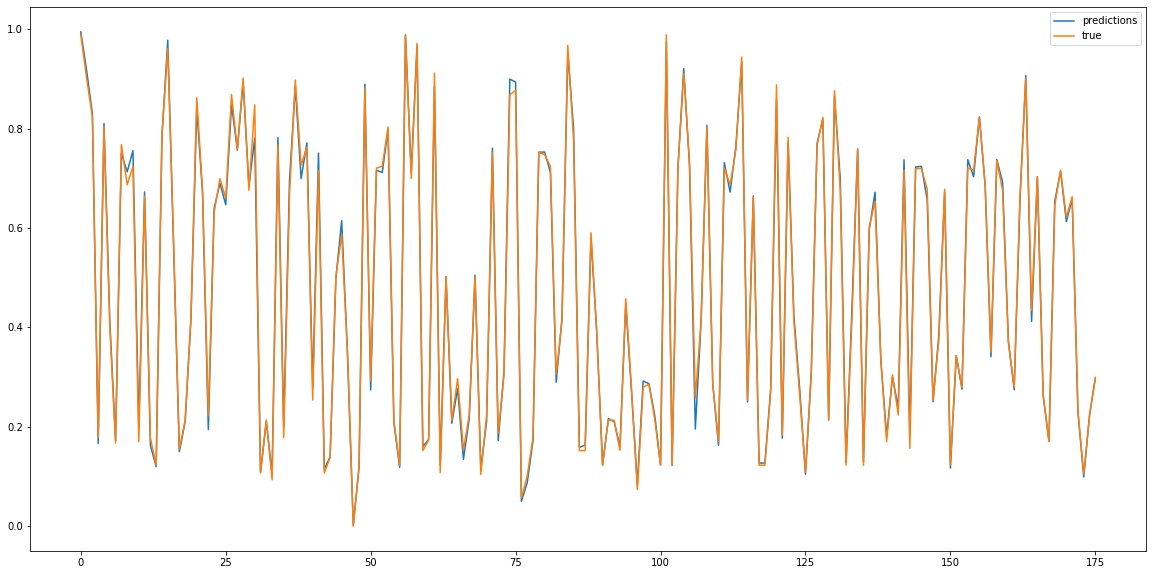

 24%|██▍       | 61/250 [00:10<00:38,  4.88it/s]/home/kishan/Documents/Projects/deepsurvival/deep_survival/lib/python3.8/site-packages/torch/nn/modules/loss.py:446: UserWarning:

Using a target size (torch.Size([1, 16, 7])) that is different to the input size (torch.Size([16, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

 32%|███▏      | 80/250 [00:13<00:26,  6.47it/s]

Epoch =  80
Loss =  tensor(0.0032)


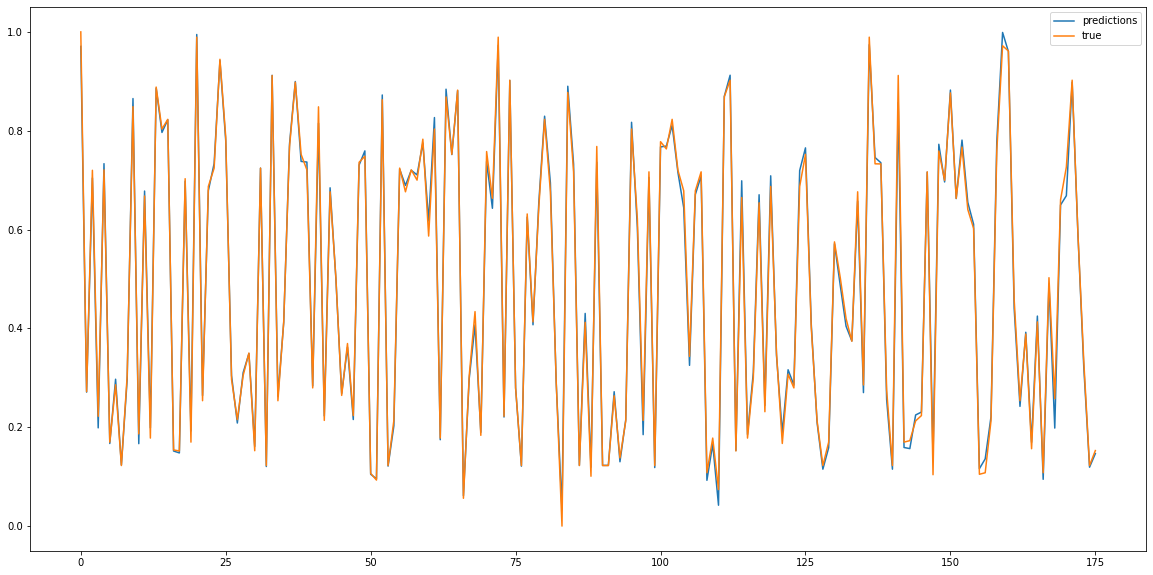

 32%|███▏      | 81/250 [00:14<00:35,  4.81it/s]/home/kishan/Documents/Projects/deepsurvival/deep_survival/lib/python3.8/site-packages/torch/nn/modules/loss.py:446: UserWarning:

Using a target size (torch.Size([1, 16, 7])) that is different to the input size (torch.Size([16, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

 40%|████      | 100/250 [00:17<00:21,  6.86it/s]

Epoch =  100
Loss =  tensor(0.0034)


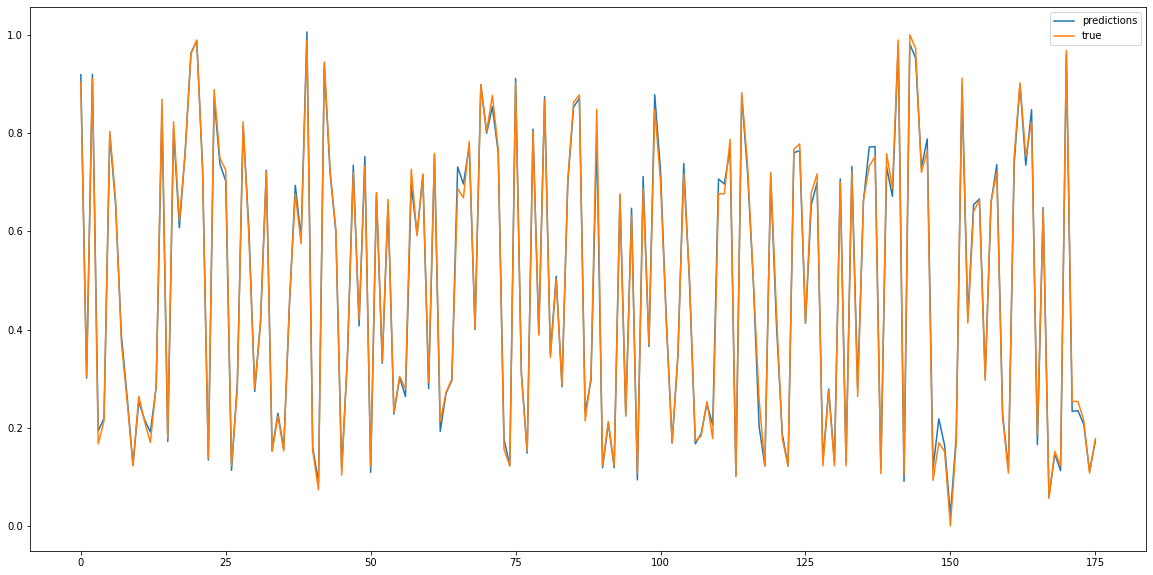

 40%|████      | 101/250 [00:17<00:30,  4.88it/s]/home/kishan/Documents/Projects/deepsurvival/deep_survival/lib/python3.8/site-packages/torch/nn/modules/loss.py:446: UserWarning:

Using a target size (torch.Size([1, 16, 7])) that is different to the input size (torch.Size([16, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

 48%|████▊     | 120/250 [00:20<00:19,  6.74it/s]

Epoch =  120
Loss =  tensor(0.0032)


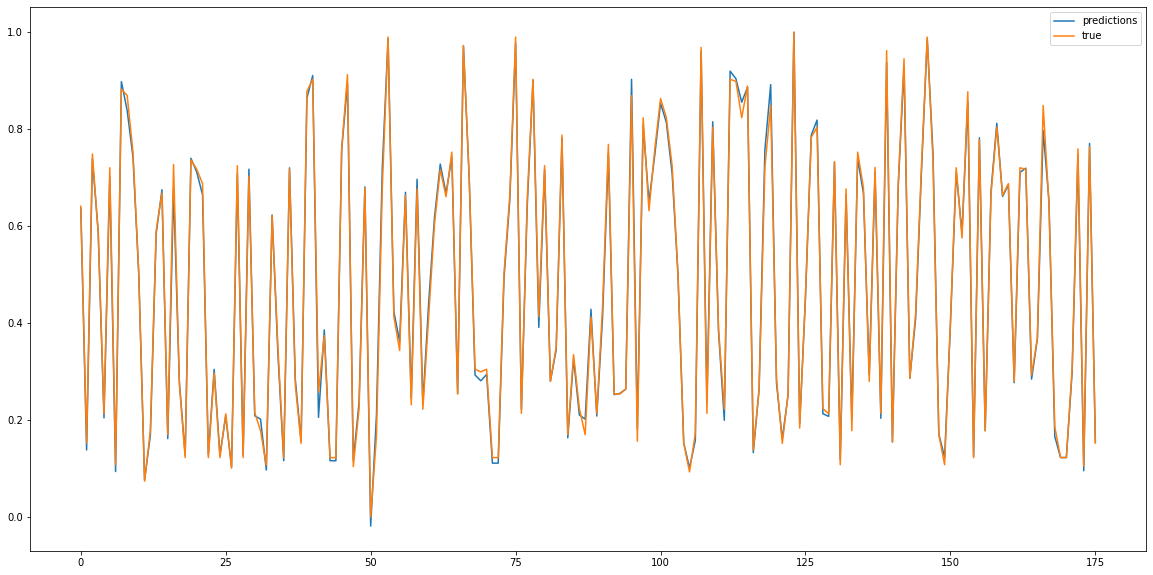

 48%|████▊     | 121/250 [00:20<00:25,  5.00it/s]/home/kishan/Documents/Projects/deepsurvival/deep_survival/lib/python3.8/site-packages/torch/nn/modules/loss.py:446: UserWarning:

Using a target size (torch.Size([1, 16, 7])) that is different to the input size (torch.Size([16, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

 56%|█████▌    | 140/250 [00:23<00:15,  7.00it/s]

Epoch =  140
Loss =  tensor(0.0022)


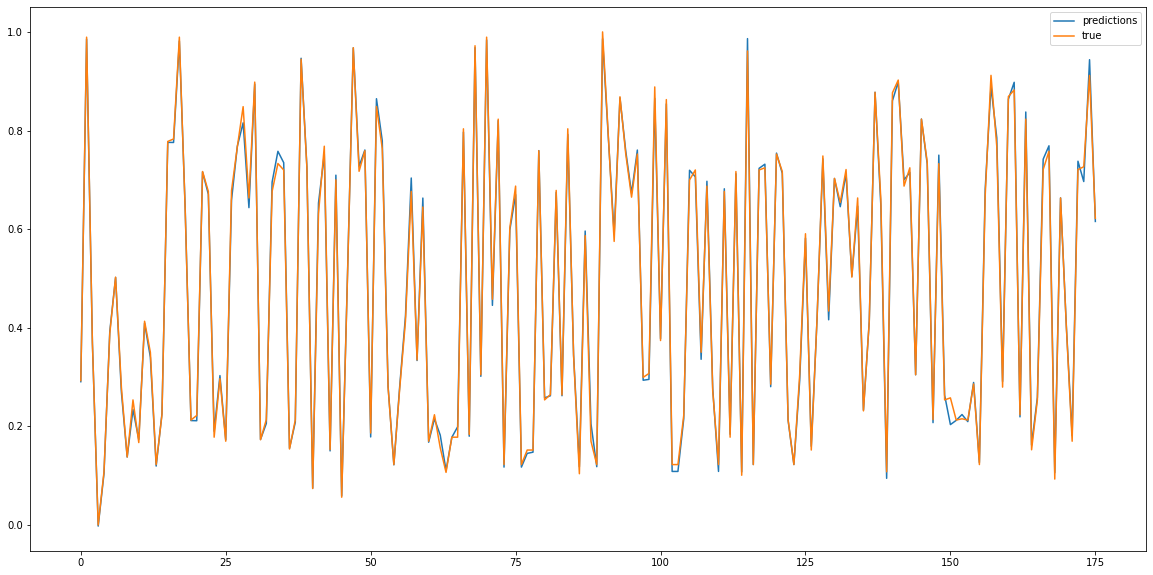

 56%|█████▋    | 141/250 [00:24<00:21,  5.12it/s]/home/kishan/Documents/Projects/deepsurvival/deep_survival/lib/python3.8/site-packages/torch/nn/modules/loss.py:446: UserWarning:

Using a target size (torch.Size([1, 16, 7])) that is different to the input size (torch.Size([16, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

 64%|██████▍   | 160/250 [00:27<00:13,  6.85it/s]

Epoch =  160
Loss =  tensor(0.0028)


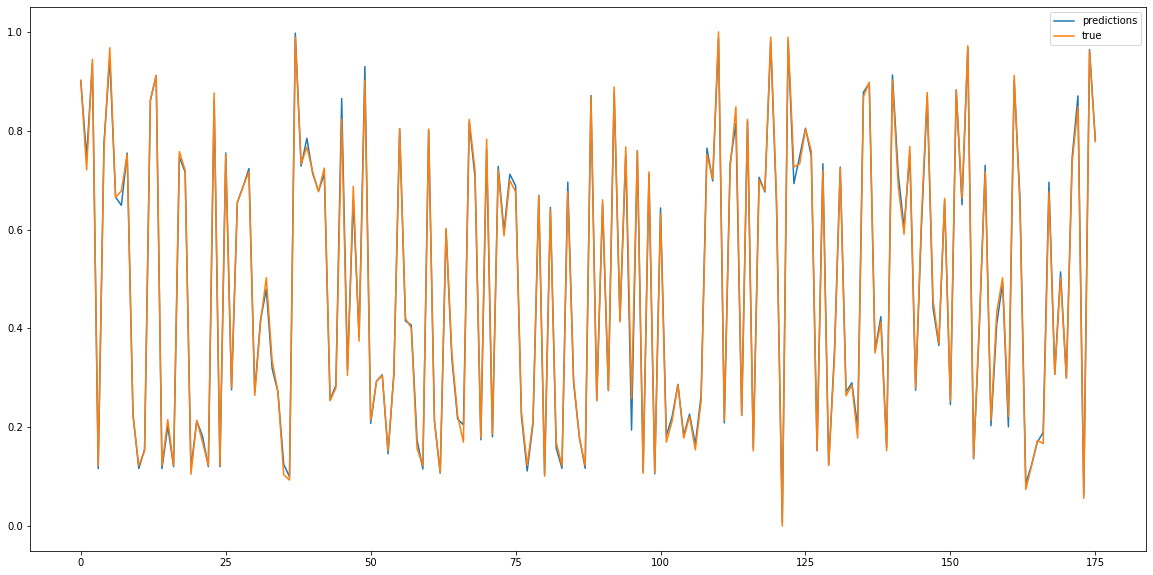

 64%|██████▍   | 161/250 [00:27<00:17,  5.02it/s]/home/kishan/Documents/Projects/deepsurvival/deep_survival/lib/python3.8/site-packages/torch/nn/modules/loss.py:446: UserWarning:

Using a target size (torch.Size([1, 16, 7])) that is different to the input size (torch.Size([16, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

 72%|███████▏  | 180/250 [00:30<00:10,  6.70it/s]

Epoch =  180
Loss =  tensor(0.0053)


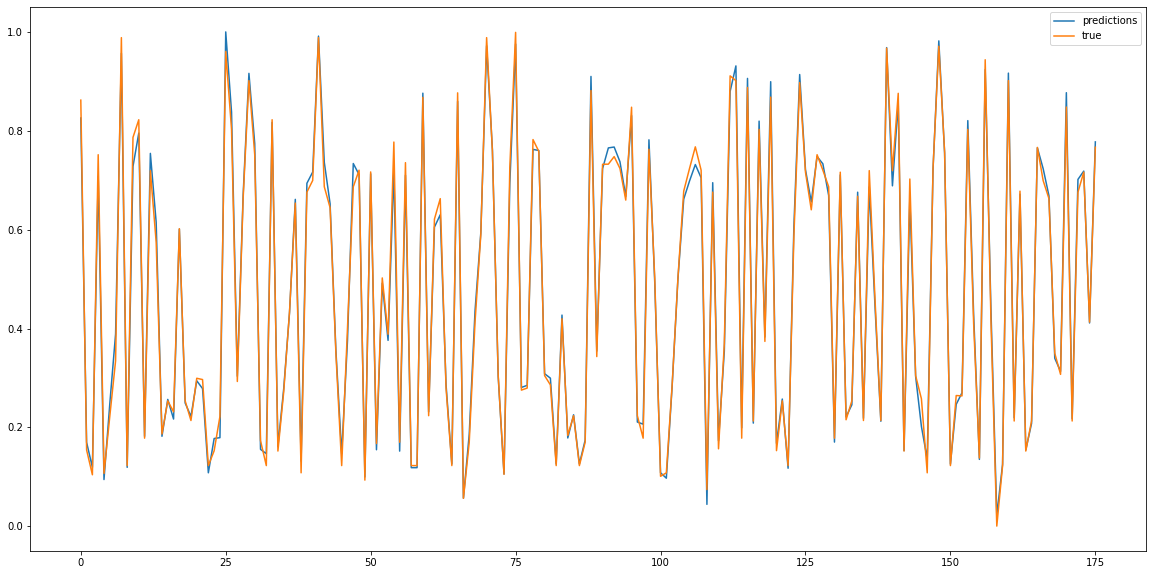

 72%|███████▏  | 181/250 [00:30<00:13,  4.98it/s]/home/kishan/Documents/Projects/deepsurvival/deep_survival/lib/python3.8/site-packages/torch/nn/modules/loss.py:446: UserWarning:

Using a target size (torch.Size([1, 16, 7])) that is different to the input size (torch.Size([16, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

 80%|████████  | 200/250 [00:33<00:07,  6.35it/s]

Epoch =  200
Loss =  tensor(0.0026)


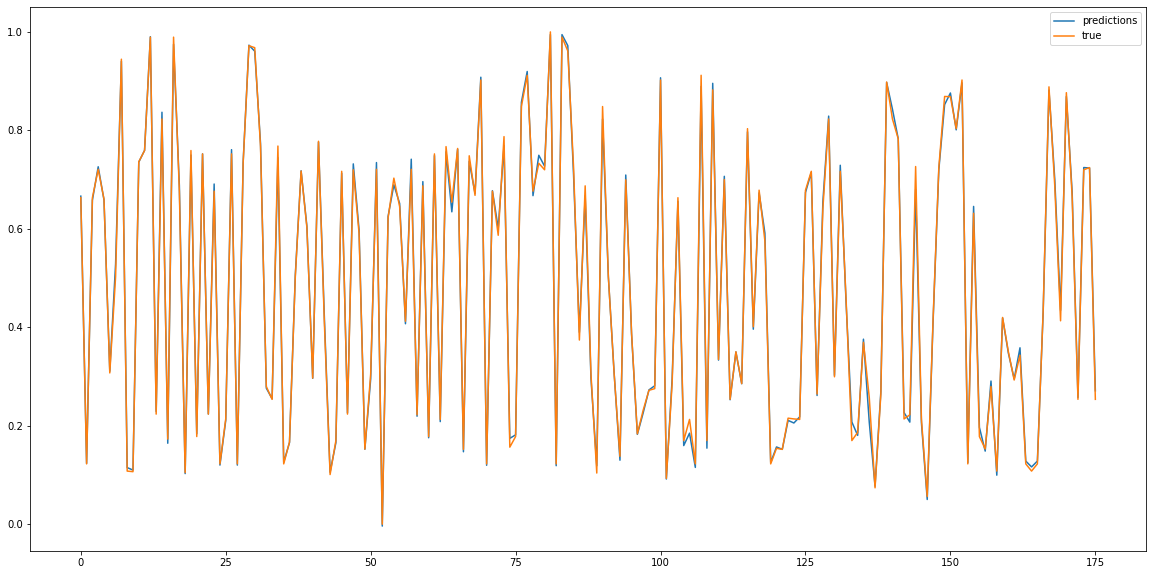

 80%|████████  | 201/250 [00:33<00:10,  4.63it/s]/home/kishan/Documents/Projects/deepsurvival/deep_survival/lib/python3.8/site-packages/torch/nn/modules/loss.py:446: UserWarning:

Using a target size (torch.Size([1, 16, 7])) that is different to the input size (torch.Size([16, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

 88%|████████▊ | 220/250 [00:37<00:04,  6.13it/s]

Epoch =  220
Loss =  tensor(0.0057)


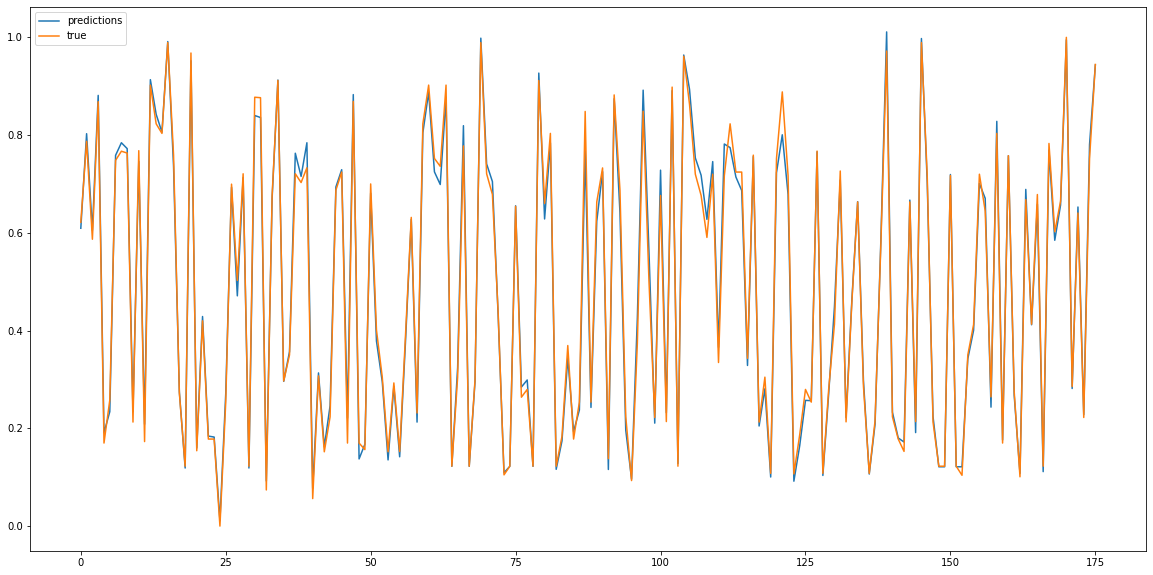

 88%|████████▊ | 221/250 [00:37<00:06,  4.51it/s]/home/kishan/Documents/Projects/deepsurvival/deep_survival/lib/python3.8/site-packages/torch/nn/modules/loss.py:446: UserWarning:

Using a target size (torch.Size([1, 16, 7])) that is different to the input size (torch.Size([16, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

 96%|█████████▌| 240/250 [00:40<00:01,  6.65it/s]

Epoch =  240
Loss =  tensor(0.0035)


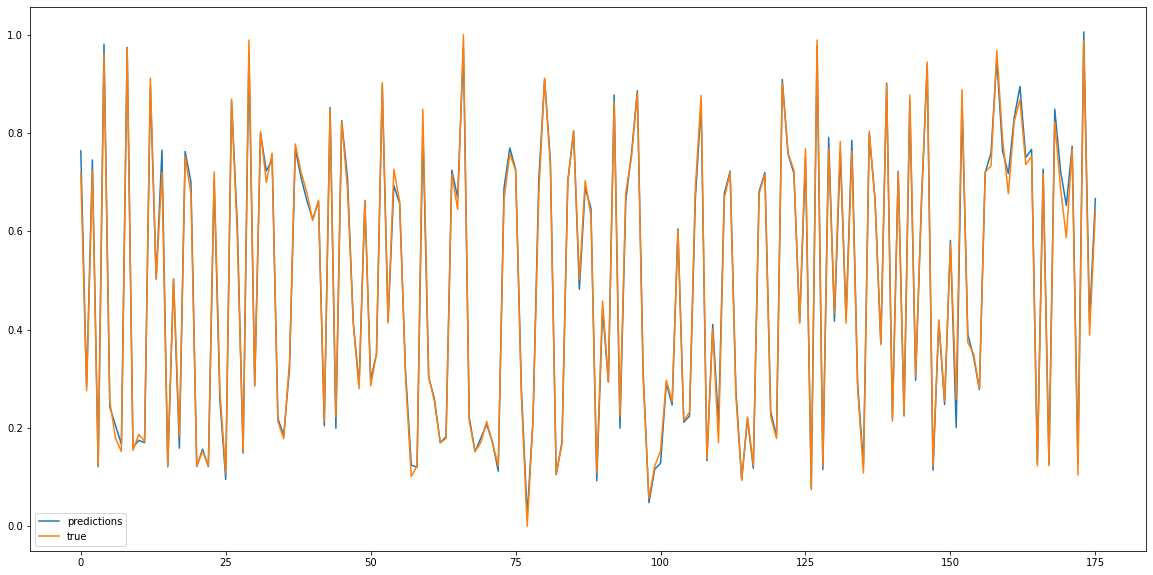

 96%|█████████▋| 241/250 [00:40<00:01,  4.82it/s]/home/kishan/Documents/Projects/deepsurvival/deep_survival/lib/python3.8/site-packages/torch/nn/modules/loss.py:446: UserWarning:

Using a target size (torch.Size([1, 16, 7])) that is different to the input size (torch.Size([16, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

100%|██████████| 250/250 [00:42<00:00,  5.89it/s]


In [98]:
losses = []
it = 0
for i in tqdm(range(max_epochs)):
    loss_ = 0.
    predicted = []
    gt = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data = Variable(data.permute(0, 2, 1)).contiguous()
        target = Variable(target.unsqueeze_(0))
        if use_cuda:
            data = data.cuda()
            target = target.cuda()
        optimizer.zero_grad()
        if target.data.size()[1] == batch_size:
            output = model(data)
            loss = criterion(output, target)
            loss_ += loss.data
            loss.backward()
            optimizer.step()
            for k in range(batch_size):
                predicted.append(output.data[k, 0])
                gt.append(target.data[:, k, 0])
        it += 1

    #print("Epoch = ", i)
    #print("Loss = ", loss_)
    losses.append(loss_.data)
    writer.add_scalar("loss_epoch", loss_, i)

    scheduler_model.step()
    
    # Plot current predictions
    
    after = 100 #plotting after 100 predictions
    
    if i % after == 0:
        print("Epoch = ", i)
        print("Loss = ", loss_.data)
        
        predicted = np.array(predicted).reshape(-1, 1)
        gt = np.array(gt).reshape(-1, 1)
        x = np.array(range(predicted.shape[0]))
        h = plt.figure(figsize = (20,10))
        
        plt.plot(x, predicted[:, 0], label="predictions")
        plt.plot(x, gt[:, 0], label="true")
        plt.legend()
        plt.show()

#torch.save(model, 'dilated_net_1d.pkl')

### Plotting Loss

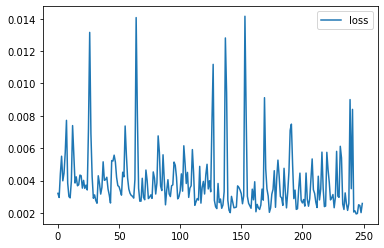

In [100]:
h = plt.figure()
x = range(len(losses))
plt.plot(x, np.array(losses), label="loss")
plt.legend()
plt.show()

## Testing

In [101]:
# TEST
predictions = np.zeros((len(train_loader.dataset.chunks), n_stocks))
ground_tr = np.zeros((len(train_loader.dataset.chunks), n_stocks))
batch_size_pred = 4

### Testing Dataset

In [102]:
# Create test data set
dtest = SP500('dataset/individual_stocks_5yr',
             symbols=symbols,
             start_date='2013-01-01',
             end_date='2013-10-31',
             T=T)
test_loader = DataLoader(dtest,
                          batch_size=batch_size_pred,
                          shuffle=False,
                          num_workers=4,
                          pin_memory=False  # CUDA only
                          )

dataset/individual_stocks_5yr/GOOGL_data.csv
dataset/individual_stocks_5yr/AAPL_data.csv
dataset/individual_stocks_5yr/AMZN_data.csv
dataset/individual_stocks_5yr/FB_data.csv
dataset/individual_stocks_5yr/ZION_data.csv
dataset/individual_stocks_5yr/NVDA_data.csv
dataset/individual_stocks_5yr/GS_data.csv


In [103]:
# Create list of n_stocks lists for storing predictions and GT
predictions = [[] for i in repeat(None, len(symbols))]
gts = [[] for i in repeat(None, len(symbols))]
k = 0

In [ ]:
# Predictions
for batch_idx, (data, target) in enumerate(test_loader):
    data = Variable(data.permute(0, 2, 1)).contiguous()
    target = Variable(target.unsqueeze_(1))
    if use_cuda:
        data = data.cuda()
        target = target.cuda()
    if target.data.size()[0] == batch_size_pred:
        output = model(data)
        for k in range(batch_size_pred):
            s = 0
            for stock in symbols:
                predictions[s].append(output.data[k, s])
                gts[s].append(target.data[k, 0, s])
                s += 1
        k += 1

In [104]:
# Plot results
# Convert lists to np array for plot, and rescaling to original data
if len(symbols) == 1:
    pred = dtest.scaler.inverse_transform(np.array(predictions[0]).reshape((len(predictions[0]), 1)))
    gt = dtest.scaler.inverse_transform(np.array(gts[0]).reshape(len(gts[0]), 1))
if len(symbols) >= 2:
    p = np.array(predictions)
    pred = dtest.scaler.inverse_transform(np.array(predictions).transpose())
    gt = dtest.scaler.inverse_transform(np.array(gts).transpose())

x = np.array(range(pred.shape[0]))
x = [np.datetime64(start_date) + np.timedelta64(x, 'D') for x in range(0, pred.shape[0])]
x = np.array(x)
months = mdates.MonthLocator(range(1, 10), bymonthday=1, interval=1)
monthsFmt = mdates.DateFormatter("%b '%y")

### Final Results

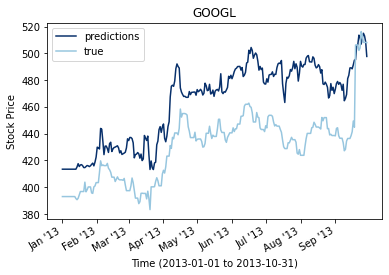

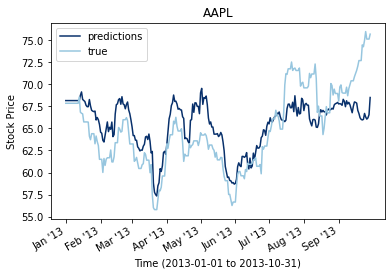

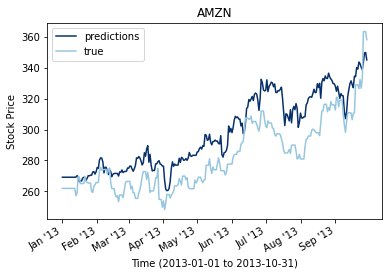

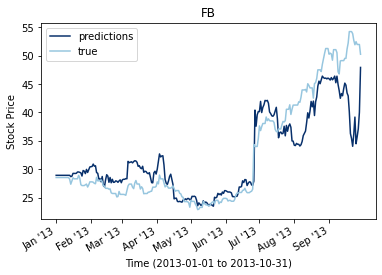

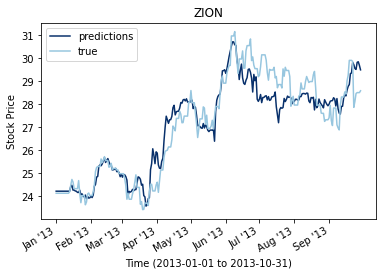

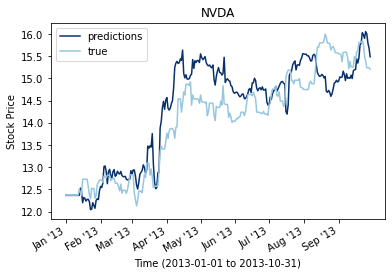

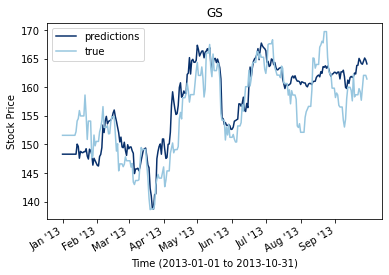

In [105]:
s = 0
# Plot and save each plot
for stock in symbols:
    fig, ax = plt.subplots()
    plt.plot(x, pred[:, s], label="predictions", color=cm.Blues(300))
    plt.plot(x, gt[:, s], label="true", color=cm.Blues(100))
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(monthsFmt)
    plt.title(stock)
    plt.xlabel("Time (2013-01-01 to 2013-10-31)")
    plt.ylabel("Stock Price")
    plt.legend()
    fig.autofmt_xdate()
    plt.savefig(stock + '.png')
    plt.show()
    s += 1